# Compare fit results to published values

This notebook compares fit results from SNCosmo with fit results published by SDSS and DES.

In [4]:
import numpy as np
import sncosmo
from astropy.table import Table, join
from matplotlib import pyplot as plt

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import Span, HoverTool, ColumnDataSource
from bokeh.layouts import gridplot
from tqdm import tqdm

import sys; sys.path.insert(0, '../')
from data_access import sdss_data, des_data

In [5]:
# Set up bokeh plotting
output_notebook()
_basic_tools = "save,pan,box_zoom,reset,wheel_zoom".split(',')


Loading BokehJS ...

## Plotting functions

Since we will be creating the same plots for multiple data sets, we create some generic plotting functions. We create a static version of the plot zoomed in to show detail, along with an interactive version that defaults to show all available data. Note that we assume the colum names of the data tables being plotted.

In [6]:
def create_static_figure(fit_data, survey_name):
    """Return a matplotlib figure comparing x0, x1, c, and chisq
    of the published and SNCosmo fit values.
    
    Args:
        fit_data  (Table): A table of data to plot
        survey_name (str): Name of the survey being plotted
        
    Returns:
         A matplotlib figure object
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    line = np.arange(-20, 20)

    for axis, value in zip(axes, ['x0', 'x1', 'c']):
        axis.plot(line, line, linestyle='--', color='grey')
        axis.errorbar(fit_data['{}_{}'.format(value, survey_name)], 
                      fit_data['{}_sncosmo'.format(value)], 
                      xerr=fit_data['{}_{}_err'.format(value, survey_name)],
                      yerr=fit_data['{}_err_sncosmo'.format(value)], 
                      linestyle='',
                      alpha=.3)

    
    reduced_chisq_survey = fit_data['chisq_{}'.format(survey_name)] / fit_data['ndof_{}'.format(survey_name)]
    reduced_chisq_sncosmo = fit_data['chisq_sncosmo'] / fit_data['ndof_sncosmo']
    axes[3].plot(line, line, linestyle='--', color='grey', alpha=.6)
    axes[3].scatter(reduced_chisq_survey, 
                    reduced_chisq_sncosmo, 
                    alpha=.3, s=10)

    axes[0].set_title('x0')
    axes[0].set_ylabel('SNCosmo Fit ugriz')

    axes[1].set_title('x1')

    axes[2].set_title('c')
    axes[2].set_xlabel('Published Value')
    axes[2].set_ylabel('SNCosmo Fit ugriz')

    axes[3].set_xlabel('Published Value')
    axes[3].set_title('chi2')
    
    return axes


def create_interactive_figure(fit_data, survey_name):
    """Return a bokeh figure comparing x0, x1, c, and chisq
    of the published and SNCosmo fit values.
    
    Args:
        fit_data  (Table): A table of data to plot
        survey_name (str): Name of the survey being plotted
        
    Returns:
         A bokeh figure object
    """
        
    data_dict = {col.name: np.array(col) for col in fit_data.itercols()}
    source = ColumnDataSource(data=data_dict)

    hover = HoverTool(tooltips=[
            ("target", "@cid"),
            ("class", "@class"),
            ("z", "@z"),
            ('z_fit', '@fit_z'),
            ('chi2', '@chi'),
            ('dof', '@dof'),
        ])

    figures = []
    for value in ('x0', 'x1', 'c', 'chisq'):
        fig = figure(tools=_basic_tools + [hover, 'box_select', 'lasso_select'], title=value)
        fig.circle('{}_{}'.format(value, survey_name), 
                   '{}_sncosmo'.format(value), 
                   source=source, size=4, alpha=.5)
        
        fig.xaxis.axis_label = 'Published Value'
        fig.yaxis.axis_label = 'SNCosmo Fit ugriz'
        figures.append(fig)
    
    return gridplot(figures, ncols=2, plot_width=350, plot_height=350)


## SDSS

We create a table to store both the published and SNCosmo fit results for SDSS. Then we plot correlations between both data sets for the fit parameters x0, x1 (stretch), and c (color) along with normalized chi-squared.

In [15]:
# Get SDSS published data
sdss_published = sdss_data.master_table[
    'CID',
    'x0SALT2zspec', 
    'x0errSALT2zspec', 
    'x1SALT2zspec', 
    'x1errSALT2zspec', 
    'cSALT2zspec', 
    'cerrSALT2zspec',
    'chi2SALT2zspec',
    'ndofSALT2zspec'
]

# Rename columns for consistancy
sdss_published.rename_column('CID', 'cid')
sdss_published.rename_column('x0SALT2zspec', 'x0_sdss')
sdss_published.rename_column('x0errSALT2zspec', 'x0_sdss_err')
sdss_published.rename_column('x1SALT2zspec', 'x1_sdss')
sdss_published.rename_column('x1errSALT2zspec', 'x1_sdss_err')
sdss_published.rename_column('cSALT2zspec', 'c_sdss')
sdss_published.rename_column('cerrSALT2zspec', 'c_sdss_err')
sdss_published.rename_column('chi2SALT2zspec', 'chisq_sdss')
sdss_published.rename_column('ndofSALT2zspec', 'ndof_sdss')

# Get SNCosmo fit data
sdss_sncosmo = Table.read('sdss_results/snia_ugriz.csv')
sdss_sncosmo.rename_column('x0', 'x0_sncosmo')
sdss_sncosmo.rename_column('x0_err', 'x0_err_sncosmo')
sdss_sncosmo.rename_column('x1', 'x1_sncosmo')
sdss_sncosmo.rename_column('x1_err', 'x1_err_sncosmo')
sdss_sncosmo.rename_column('c', 'c_sncosmo')
sdss_sncosmo.rename_column('c_err', 'c_err_sncosmo')
sdss_sncosmo.rename_column('chi', 'chisq_sncosmo')
sdss_sncosmo.rename_column('dof', 'ndof_sncosmo')

# Combine tables and keep only SN with published fits
combined_sdss = join(sdss_sncosmo, sdss_published)
combined_sdss = combined_sdss[~combined_sdss['x0_sdss'].mask]   
combined_sdss[:5].show_in_notebook()


idx,cid,class,num_points_sdssu,num_points_sdssg,num_points_sdssr,num_points_sdssi,num_points_sdssz,fit_z,z,t0,x0_sncosmo,x1_sncosmo,c_sncosmo,z_err,t0_err,x0_err_sncosmo,x1_err_sncosmo,c_err_sncosmo,chisq_sncosmo,ndof_sncosmo,message,x0_sdss,x0_sdss_err,x1_sdss,x1_sdss_err,c_sdss,c_sdss_err,chisq_sdss,ndof_sdss
0,694,Unknown,35,37,38,38,38,0,0.127493,53623.77216146062,4.504195124901735e-05,0.8525009696882381,0.33541832755726647,nan,6.076528734411113e-05,5.847310908768368e-07,0.14318704480817337,0.011602271088007623,1015.5583713366084,144.0,Covariance may not be accurate.,0.000216,1.09e-05,1.38,0.21,0.23,0.03,186.2,73
1,703,zSNIa,20,22,22,22,22,0,0.298042,53626.537638665584,1.313527839181647e-05,0.624903505556212,0.035025410977721945,nan,0.6043930548985372,6.03121072391653e-07,0.5981203647495589,0.03781555481660669,97.54570975395427,104.0,Minimization exited successfully.,5.43e-05,3.47e-06,0.73,0.63,-0.01,0.05,40.8,59
2,716,zSNII,40,42,41,42,39,0,0.324,53578.62668582601,0.0002858469394610859,0.39829614457767504,-0.40032131126505127,nan,0.23125855026592035,3.4055207983159265e-06,0.014228581707102173,0.004094827667645987,17483.995126547437,200.0,Minimization exited successfully.,0.000167,4.38e-06,5.0,0.01,-0.11,0.02,794.1,131
3,717,Unknown,20,20,20,20,20,0,0.130392,53613.723654223526,5.1869500616666264e-06,0.20422405095650092,1.0983885681891299,nan,0.004435393104358809,8.08315570245059e-07,0.8213889836446174,0.11360379280249555,100.63808216742385,76.0,Covariance may not be accurate.,2.24e-05,4.01e-06,0.69,1.05,0.98,0.11,36.2,41
4,735,zSNIa,20,21,20,20,21,0,0.190858,53610.741947364426,2.3046325820095966e-05,-2.5645535823024708,0.024691058937044267,nan,0.0009846973480307497,1.4834865953930549e-06,0.4169127372878672,0.059408219959235356,76.2610493593063,77.0,Covariance may not be accurate.,8.82e-05,1.23e-05,-2.66,0.58,0.01,0.09,20.6,33


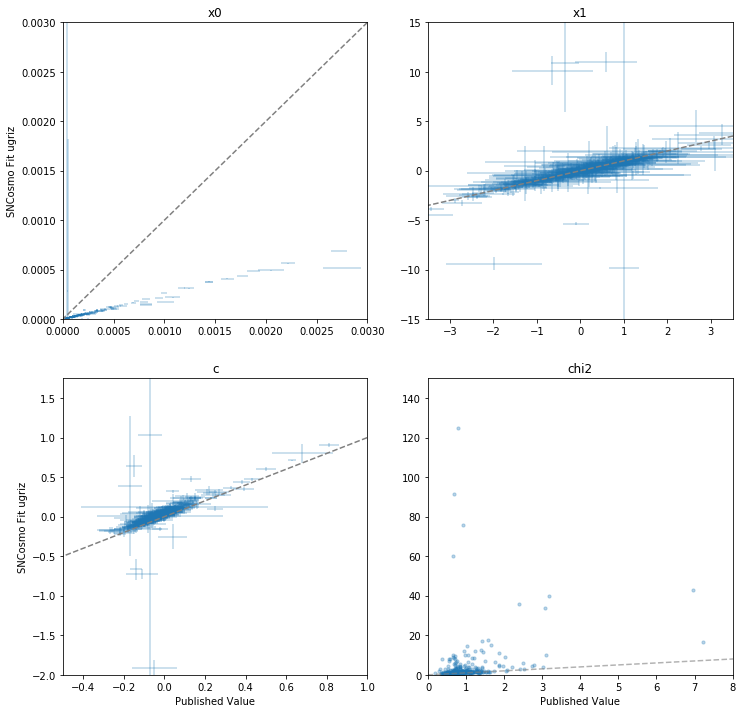

In [8]:
# Consider only type 1a objects
fit_data = combined_sdss[combined_sdss['class'] == 'SNIa']
plot_axes = create_static_figure(fit_data, 'sdss')

plot_axes[0].set_xlim(0, .003)
plot_axes[0].set_ylim(0, .003)
plot_axes[1].set_xlim(-3.5, 3.5)
plot_axes[1].set_ylim(-15, 15)
plot_axes[2].set_xlim(-.5, 1)
plot_axes[2].set_ylim(-2, 1.75)
plot_axes[3].set_xlim(0, 8)
plot_axes[3].set_ylim(0, 150)

plt.show()

In [9]:
plot_grid = create_interactive_figure(fit_data, 'sdss')
show(plot_grid)


## DES

As before, we create a table to store both the published and SNCosmo fit results and plot the correlation.

In [10]:
# Get DES published data
des_published = des_data.master_table[
    'CID',
    'x0',
    'x0ERR',
    'x1',
    'x1ERR',
    'c',
    'cERR',
    'FITCHI2',
    'NDOF'
]

des_published.rename_column('CID', 'cid')
des_published.rename_column('x0', 'x0_des')
des_published.rename_column('x0ERR', 'x0_des_err')
des_published.rename_column('x1', 'x1_des')
des_published.rename_column('x1ERR', 'x1_des_err')
des_published.rename_column('c', 'c_des')
des_published.rename_column('cERR', 'c_des_err')
des_published.rename_column('FITCHI2', 'chisq_des')
des_published.rename_column('NDOF', 'ndof_des')

# Get SNCosmo fit data
des_sncosmo = Table.read('des_results/snia_ugriz.csv')
des_sncosmo.rename_column('x0', 'x0_sncosmo')
des_sncosmo.rename_column('x0_err', 'x0_err_sncosmo')
des_sncosmo.rename_column('x1', 'x1_sncosmo')
des_sncosmo.rename_column('x1_err', 'x1_err_sncosmo')
des_sncosmo.rename_column('c', 'c_sncosmo')
des_sncosmo.rename_column('c_err', 'c_err_sncosmo')
des_sncosmo.rename_column('chi', 'chisq_sncosmo')
des_sncosmo.rename_column('dof', 'ndof_sncosmo')
des_sncosmo['cid'] = [str(x) for x in des_sncosmo['obj_id']]

# Combine tables and keep only SN with published fits
combined_des = join(des_sncosmo, des_published)
combined_des[:5].show_in_notebook()


idx,obj_id,z,z_err,num_points_desg,num_points_desr,num_points_desi,num_points_desz,num_points_desy,t0,x0_sncosmo,x1_sncosmo,c_sncosmo,t0_err,x0_err_sncosmo,x1_err_sncosmo,c_err_sncosmo,chisq_sncosmo,ndof_sncosmo,message,cid,x0_des,x0_des_err,x1_des,x1_des_err,c_des,c_des_err,chisq_des,ndof_des
0,1248677,0.3502,0.001,0,13,17,16,0,56554.01528487016,5.241497768700183e-07,0.6687845357586243,0.2157923354512705,0.09140854055294767,7.030474090787751e-09,0.09066974167139438,0.010819628448171711,773.3139757152373,42.0,Minimization exited successfully.,1248677,4.40037e-05,1.10963e-06,1.0022,0.1137,-0.110622,0.0219627,27.7196,43
1,1250017,0.1817,0.001,0,16,15,15,0,56553.70996804125,6.680571118859516e-06,0.9440140267713572,-0.2629848619195618,0.10302910995960701,1.855628245141032e-07,0.1518095968620506,0.019413583960992215,297.55215889881964,42.0,Minimization exited successfully.,1250017,0.000172073,5.42081e-06,0.9524,0.155,-0.0923231,0.0261938,33.4843,32
2,1253039,0.4535,0.006,0,0,18,20,0,56575.48129358581,4.294531838322999e-07,-0.1373243695178179,0.37601898825366714,0.505406563381257,3.946383966584294e-08,0.44684914944545284,0.07878116032833328,30.797585069874806,34.0,Minimization exited successfully.,1253039,2.13955e-05,6.10291e-07,0.3513,0.2695,-0.0968782,0.0276632,34.4664,45
3,1253101,0.4596,0.0005,0,0,18,17,0,56577.1830353626,3.7843469433464436e-07,1.4624423496483352,0.4924224037662031,0.7153056181196007,4.404245824923522e-08,0.57898092249036,0.10033131236350308,47.80141502194499,31.0,Minimization exited successfully.,1253101,1.91429e-05,7.11689e-07,1.4335,0.3766,0.0135675,0.032692,50.3317,39
4,1253920,0.1956,0.001,0,15,14,15,0,56583.455567012665,5.021607672912761e-06,-0.7711840505117142,-0.17523201517008724,0.11627207146011642,1.6536384996688555e-07,0.14192877622513972,0.024870442493059593,390.8054862007647,40.0,Minimization exited successfully.,1253920,0.000130587,4.02852e-06,-0.733173,0.1382,-0.0843909,0.0277645,20.6679,28


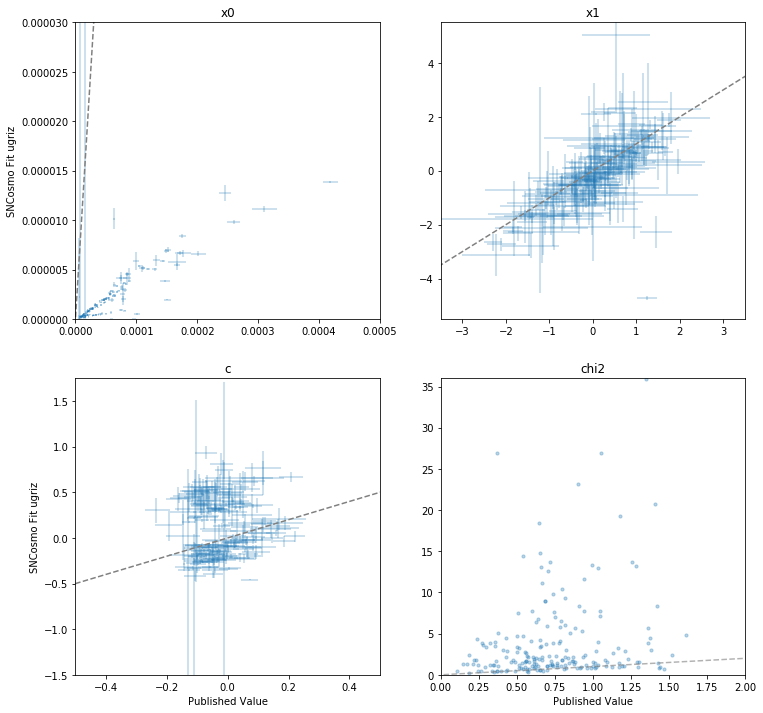

In [11]:
plot_axes = create_static_figure(combined_des, 'des')

plot_axes[0].set_xlim(0, 5e-4)
plot_axes[0].set_ylim(0, 3e-5)
plot_axes[1].set_xlim(-3.5, 3.5)
plot_axes[1].set_ylim(-5.5, 5.5)
plot_axes[2].set_xlim(-.5, .5)
plot_axes[2].set_ylim(-1.5, 1.75)
plot_axes[3].set_xlim(0, 2)
plot_axes[3].set_ylim(0, 36)

plt.show()


In [12]:
plot_grid = create_interactive_figure(combined_des, 'des')
show(plot_grid)


## Exploring disagreements bewteen DES results

Lets inspect a few light curves where the chi-squared values differ significantly between the published and SNCsomo fit results. We can then fit the lightcurve in SNCosmo with and without specifying the published value of each parameter and compare the results.


In [13]:
col_names = ['cid', 'z_sncosmo','t0_sncosmo', 
             'x0_sncosmo', 'x1_sncosmo', 'c_sncosmo', 
             'chisq_sncosmo', 'ndof_sncomso']

test_fit_results = Table(names=col_names,
    dtype = ['S30'] + [float for _ in col_names[:-1]],
)

for input_table in des_data.iter_sncosmo_input(verbose=True):
    cid = str(input_table.meta['obj_id'])
    published_values = des_published[des_published['cid'] == cid]
    x0 = published_values['x0_des']
    x1 = published_values['x1_des']
    c = published_values['c_des']
    
    model = sncosmo.Model(source='salt2')
    model.set(z=input_table.meta['redshift'], x0=x0, x1=x1, c=c)
    
    try:
        result, fitted_model = sncosmo.fit_lc(
            input_table, model, ['t0'], bounds=None)

        new_row = [cid]
        new_row.extend(result.parameters)
        new_row.append(result.chisq)
        new_row.append(result.ndof)
        test_fit_results.add_row(new_row)
        
    except:
        tqdm.write('Failed: ' + cid)



 46%|████▋     | 96/207 [00:08<00:10, 10.26it/s]/anaconda3/envs/sdss_classification_2.7/lib/python2.7/site-packages/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: desz(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)
100%|██████████| 207/207 [00:16<00:00, 12.36it/s]


In [14]:
plot_data = join(test_fit_results, des_published)
plot_grid = create_interactive_figure(plot_data, 'des')
show(plot_grid)

plot_data[:5].show_in_notebook()

idx,cid,z_sncosmo,t0_sncosmo,x0_sncosmo,x1_sncosmo,c_sncosmo,chisq_sncosmo,ndof_sncomso,x0_des,x0_des_err,x1_des,x1_des_err,c_des,c_des_err,chisq_des,ndof_des
0,1248677,0.3502,56553.993710932446,4.40037e-05,1.0022,-0.110622,7049.330188481326,58.0,4.40037e-05,1.10963e-06,1.0022,0.1137,-0.110622,0.0219627,27.7196,43
1,1250017,0.1817,56554.421204482685,0.000172073,0.9524,-0.0923231,10952.791805758583,59.0,0.000172073,5.42081e-06,0.9524,0.155,-0.0923231,0.0261938,33.4843,32
2,1253039,0.4535,56576.62736906189,2.13955e-05,0.3513,-0.0968782,553.8517505103717,73.0,2.13955e-05,6.10291e-07,0.3513,0.2695,-0.0968782,0.0276632,34.4664,45
3,1253101,0.4596,56578.19976577471,1.91429e-05,1.4335,0.0135675,322.8686363236133,67.0,1.91429e-05,7.11689e-07,1.4335,0.3766,0.0135675,0.032692,50.3317,39
4,1253920,0.1956,56583.959793176145,0.000130587,-0.733173,-0.0843909,2341.358676103063,57.0,0.000130587,4.02852e-06,-0.733173,0.1382,-0.0843909,0.0277645,20.6679,28


In [ ]:


test_ids = (1308884, 1342255)

for test_id in test_ids:
    input_table = des_data.get_input_for_id(test_id)

    # Get published values
    published_values = des_published[des_published['cid'] == str(test_id)]
    x0 = published_values['x0_des'][0]
    x1 = published_values['x1_des'][0]
    c = published_values['c_des'][0]

    print('Published Values:')
    print('x0: ', x0)
    print('x1: ', x1)
    print('c: ', c)

    print('Fitting for all terms except z:')
    model = sncosmo.Model(source='salt2')
    model.set(z=input_table.meta['redshift'])

    result, fitted_model = sncosmo.fit_lc(input_table, model, ['t0', 'x0', 'x1', 'c'], bounds=None)
    result['chi2_norm'] = (result.chisq / result.ndof)
    sncosmo.plot_lc(input_table, model=fitted_model, errors=result.errors)
    plt.show()
    print(result)

    print('\n\nFitting with fixed, published values:')
    model.set(z=input_table.meta['redshift'], x0=x0, x1=x1, c=c)
    result, fitted_model = sncosmo.fit_lc(input_table, model, ['t0'], bounds=None)
    result['chi2_norm'] = (result.chisq / result.ndof)
    sncosmo.plot_lc(input_table, model=fitted_model, errors=result.errors)
    plt.show()
    print(result)
    print('\n\n\n')